# Fine-tuning with transformers' library

Instead of extracting features, and then applying a different machine learning model, we can use the `transformers` library to fine-tune a pre-trained model, continuing the training on a pre-trained model from Hugging Face's Hub with our own data.

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

## Example: SMS Spam detection

In this example, we will fine-tune a pre-trained BERT model to classify SMS messages as spam or not spam.

This is the dataset we want to use: https://huggingface.co/datasets/sms_spam

1. Load the dataset in hf's format.

Note that since in the previous webpage, the data only has a single split ("train"), we will have to split it ourselves:

In [2]:
raw_dataset_train = load_dataset("sms_spam", split="train[:50%]")
raw_dataset_val = load_dataset("sms_spam", split="train[50%:]")

In [3]:
raw_dataset_train

Dataset({
    features: ['sms', 'label'],
    num_rows: 2787
})

In [5]:
raw_dataset_train[5]

{'sms': "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\n",
 'label': 1}

For exploratory purposes, we can convert a hf's dataset into a pandas dataframe:

In [6]:
dataset_df = raw_dataset_train.to_pandas()

dataset_df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


It seems that label 1 refers to spam, and label 0 refers to not spam.

<AxesSubplot: >

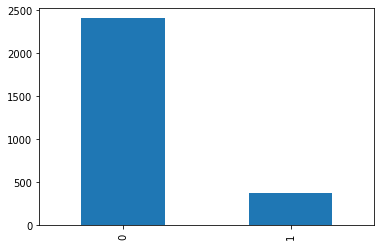

In [7]:
dataset_df.label.value_counts().plot(kind='bar')

2. Chosing a pre-trained model (and corresponding tokenizer) to tokenize the dataset.

We want to fine-tune the bert model. We load its tokenizer first, and apply it to the dataset splits.

![](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)

Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

* Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
* Mapping each token to an integer
* Adding additional inputs that may be useful to the model
  
All this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub. To do this, we use the AutoTokenizer class and its from_pretrained() method. Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(example):
    return tokenizer(example["sms"], truncation=True)


tokenized_datasets_train = raw_dataset_train.map(tokenize_function, batched=True)
tokenized_datasets_val = raw_dataset_val.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2787 [00:00<?, ? examples/s]

Now we can load the pre-trained model:

The AutoModelForSequenceClassification class is a powerful tool that allows us to use a pre-trained model to classify sequences of text. It modifies the last layers of the pre-trained BERT model to make it compatible with a classification task.

In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

3. Training the model

The first step before we can define our Trainer is to define a TrainingArguments class that will contain all the hyperparameters the Trainer will use for training and evaluation. The only argument you have to provide is a directory where the trained model will be saved, as well as the checkpoints along the way. For all the rest, you can leave the defaults, which should work pretty well for a basic fine-tuning.

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments("experiment-spam", per_device_train_batch_size=16, logging_steps=10)

Once we have our model, we can define a Trainer by passing it all the objects constructed up to now — the model, the training_args, the training and validation datasets, our data_collator, and our tokenizer:

In [13]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


To fine-tune the model on our dataset, we just have to call the train() method of our Trainer:

In [14]:
trainer.train()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: vicgalle. Use `wandb login --relogin` to force relogin


  0%|          | 0/525 [00:00<?, ?it/s]

{'loss': 0.3912, 'grad_norm': 2.1155686378479004, 'learning_rate': 4.904761904761905e-05, 'epoch': 0.06}
{'loss': 0.1405, 'grad_norm': 13.298932075500488, 'learning_rate': 4.80952380952381e-05, 'epoch': 0.11}
{'loss': 0.12, 'grad_norm': 8.244377136230469, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.17}
{'loss': 0.0356, 'grad_norm': 0.2509291470050812, 'learning_rate': 4.6190476190476194e-05, 'epoch': 0.23}
{'loss': 0.0764, 'grad_norm': 0.3728467524051666, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.1239, 'grad_norm': 0.17081677913665771, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.34}
{'loss': 0.0772, 'grad_norm': 0.12423927336931229, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 0.0691, 'grad_norm': 7.357865333557129, 'learning_rate': 4.2380952380952385e-05, 'epoch': 0.46}
{'loss': 0.0463, 'grad_norm': 0.10748817026615143, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.51}
{'loss': 0.0744, 'grad_norm': 6.749342918395996, 'lear

KeyboardInterrupt: 

4. Evaluation

To get some predictions from our model, we can use the Trainer.predict() command:

In [15]:
predictions = trainer.predict(tokenized_datasets_val)
print(predictions.predictions.shape, predictions.label_ids.shape)

  0%|          | 0/349 [00:00<?, ?it/s]

(2787, 2) (2787,)


In this predictions object, we have both the predicted logits and the true labels:

In [17]:
predictions

PredictionOutput(predictions=array([[ 3.4188704, -3.2959225],
       [ 2.8931568, -3.0563471],
       [ 3.3770955, -3.2512643],
       ...,
       [ 3.2661016, -3.2368455],
       [ 1.9782873, -2.203987 ],
       [ 3.2964618, -3.2265937]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.041887618601322174, 'test_runtime': 41.2555, 'test_samples_per_second': 67.555, 'test_steps_per_second': 8.459})

In [20]:
predictions.predictions

array([[ 3.4188704, -3.2959225],
       [ 2.8931568, -3.0563471],
       [ 3.3770955, -3.2512643],
       ...,
       [ 3.2661016, -3.2368455],
       [ 1.9782873, -2.203987 ],
       [ 3.2964618, -3.2265937]], dtype=float32)

In [21]:
predictions.predictions.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
raw_dataset_val_df = raw_dataset_val.to_pandas()
raw_dataset_val_df['prediction'] = predictions.predictions.argmax(axis=1)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(raw_dataset_val_df['label'], raw_dataset_val_df['prediction']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2421
           1       0.97      0.96      0.96       366

    accuracy                           0.99      2787
   macro avg       0.98      0.98      0.98      2787
weighted avg       0.99      0.99      0.99      2787



Works pretty close to perfect!

### Saving a model


Once we have fine-tuned our model, we can save it to disk so that we can use it later. We can use the save_pretrained() method of our model and tokenizer:

In [25]:
model.save_pretrained("sms-spam-model") # this will be the local folder where the model will be saved
tokenizer.save_pretrained("sms-spam-model")

('sms-spam-model/tokenizer_config.json',
 'sms-spam-model/special_tokens_map.json',
 'sms-spam-model/vocab.txt',
 'sms-spam-model/added_tokens.json',
 'sms-spam-model/tokenizer.json')

Now we can load it using the pipeline, for instance:

In [26]:
from transformers import pipeline

In [27]:
classifier = pipeline("text-classification", model="sms-spam-model", tokenizer="sms-spam-model")

In [37]:
classifier("You have been chosen for 1000 dollars! Text back to claim them!")

[{'label': 'LABEL_1', 'score': 0.9311851263046265}]

In [35]:
classifier("R u ok?")

[{'label': 'LABEL_0', 'score': 0.9987093210220337}]

### Comparing with scikit-learn

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words="english")),
    ("classifier", LogisticRegression())
])

model.fit(raw_dataset_train['sms'], raw_dataset_train['label'])

y_pred = model.predict(raw_dataset_val['sms'])

print(classification_report(raw_dataset_val['label'], y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2421
           1       0.98      0.62      0.76       366

    accuracy                           0.95      2787
   macro avg       0.96      0.81      0.86      2787
weighted avg       0.95      0.95      0.94      2787



**Exercise** Find a pre-trained model that is smaller than bert-base, and fine-tune it using the same dataset. Compare the results with the ones obtained with bert-base.